<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Robot-class" data-toc-modified-id="Robot-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>Robot</code> class</a></span></li><li><span><a href="#Reinforcement-Learning-Problem-for-Controlling-the-Robot" data-toc-modified-id="Reinforcement-Learning-Problem-for-Controlling-the-Robot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reinforcement Learning Problem for Controlling the Robot</a></span></li><li><span><a href="#Reinforcement-Learning-Training-Algorithm" data-toc-modified-id="Reinforcement-Learning-Training-Algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reinforcement Learning Training Algorithm</a></span></li><li><span><a href="#Required-Experiments" data-toc-modified-id="Required-Experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Required Experiments</a></span><ul class="toc-item"><li><span><a href="#Good-parameter-values" data-toc-modified-id="Good-parameter-values-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Good parameter values</a></span></li><li><span><a href="#Create-robot-with-four-links-of-lengths,-4,-3,-3,--and-2." data-toc-modified-id="Create-robot-with-four-links-of-lengths,-4,-3,-3,--and-2.-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Create robot with four links of lengths, 4, 3, 3,  and 2.</a></span></li><li><span><a href="#Increase-number-of-valid-actions" data-toc-modified-id="Increase-number-of-valid-actions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Increase number of valid actions</a></span></li></ul></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=5>A6.2 Reinforcement Learning to Control a Robot</font>

* *A6.2:* Modified the incomplete code for the `train` function.  You can ignore this version if you have already achieved successful training of your robot.

* *A6.1:* To help you test your code, I added a call to `np.random.seed` to allow you to compare your output with mine.  At start of Section 4, I added a statement saying that you must discuss what you observe in the results.  Also added an argument to the `Robot.animate` function to allow you to draw one plot to visualize the trained robot's behavior.  

In this assignment, you will play with a simulation of a two-dimensional robot arm with multiple links and joints. You will train a neural network to approximate the Q function.

The state of the arm is just the angles of each joint.  To remove the huge difference between joint angles of 359 degrees and 1 degree as a joint moves, we will represent each joint angle with two values, the sine and cosine of the angle, as the state input to the neural network. Valid actions on each step will be $-0.1$, $0$, and $+0.1$ applied to each joint.

# `Robot` class

Here is an implementation of the robot simulation.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sys
import itertools  # for product (cross product)
from math import pi
from IPython.display import display, clear_output

Now import your `NeuralNetwork` regression class that uses `numpy` and has the `scg` optimizer available.

In [2]:
import A3mysolution as nn  # where you implement the NeuralNetwork class

In [3]:
class Robot():

    def __init__(self, link_lengths):
        self.n_links = len(link_lengths)
        self.record_angles = False
        self.angles = []
        self.link_lengths = np.array(link_lengths)
        self.joint_angles = np.zeros(self.n_links)
        self.points = [[10, 10] for _ in range(self.n_links + 1)]
        self.lim = sum(link_lengths)
        self.update_points()
        self.goal = None

    def set_goal(self, g):
        self.goal = g

    def dist_to_goal(self):
        return np.sqrt(np.sum((self.goal - self.end_effector)**2))
    
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.update_points()

    def add_to_joints(self, joint_angle_deltas):
        self.joint_angles += joint_angle_deltas
        too_high = self.joint_angles > 2 * pi
        self.joint_angles[too_high] = self.joint_angles[too_high] - 2 * pi
        too_low = self.joint_angles < 0
        self.joint_angles[too_low] = self.joint_angles[too_low] + 2 * pi
        if self.record_angles:
            self.angles.append(self.joint_angles * 180 / pi)
        self.update_points()

    def update_points(self):
        for i in range(1, self.n_links + 1):
            self.points[i][0] = (self.points[i - 1][0]
                                 + self.link_lengths[i - 1] * np.cos(np.sum(self.joint_angles[:i])))
            self.points[i][1] = (self.points[i - 1][1] +
                                 self.link_lengths[i - 1] * np.sin(np.sum(self.joint_angles[:i])))
        self.end_effector = np.array(self.points[self.n_links]).T

    def get_angles(self):
        return self.joint_angles
    

    def plot(self, style):
        for i in range(self.n_links + 1):
            if i is not self.n_links:
                plt.plot([self.points[i][0], self.points[i + 1][0]],
                         [self.points[i][1], self.points[i + 1][1]], style)
            plt.plot(self.points[i][0], self.points[i][1], 'k.')
        plt.axis('off')
        plt.axis('square')
        plt.xlim([-1, 21])
        plt.ylim([-1, 21])

    def animate(self, n_steps, Qnet=None, show_all_steps=False):
        fig = plt.figure(figsize=(8, 8))
        
        for i in range(n_steps):
            if not show_all_steps:
                fig.clf()
            plt.scatter(self.goal[0], self.goal[1], s=80)
            if Qnet:
                action, Qvalue = epsilon_greedy(self, Qnet, valid_actions, epsilon=0)
            else:
                action = [0.1] * self.n_links
            self.add_to_joints(action)
            style = 'b-' if show_all_steps and i+1 == n_steps else 'r-'
            self.plot(style)
            
            if not show_all_steps:
                clear_output(wait=True)
                display(fig)
            
        if not show_all_steps:
            clear_output(wait=True)

To use this class, first instantiate a robot by specifying the number of links and the lengths of each link as a list.  Imagine the end of the last link of the robot has a gripper. Set the goal location for the gripper by calling `robot.set_goal()`.  

Then you can animate the robot for some number of steps.

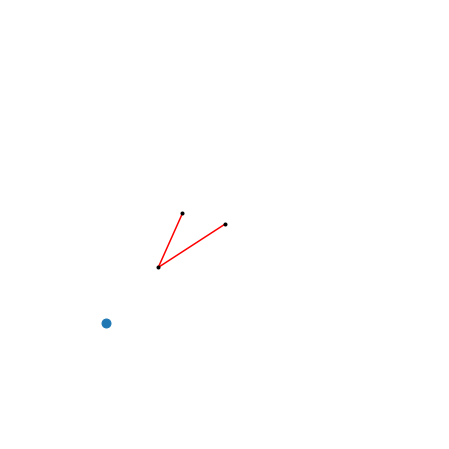

In [4]:
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100)

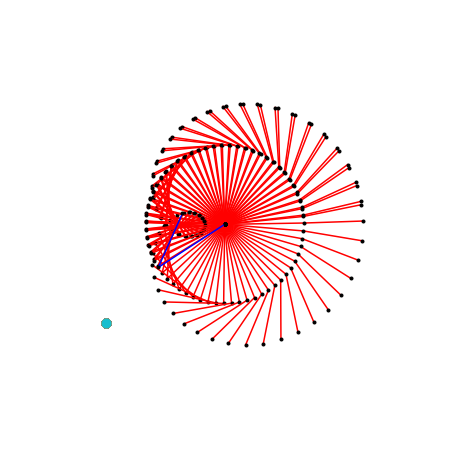

In [5]:
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100, show_all_steps=True)

# Reinforcement Learning Problem for Controlling the Robot

To define the reinforcement learning problem for controlling this robot, and trying to move the gripper as close to the goal as you can, we need to define the three main functions that define a reinforcement learning problem.  These are pretty easy with the functions available to us in the `Robot` class.  We will also need a function to represent the joint angles as sines and cosines.

In [6]:
def angles_to_sin_cos(angles):
    return np.hstack((np.sin(angles), np.cos(angles)))


def initial_state(robot):
    robot.update_joints(np.random.uniform(-2 * pi, 2 * pi, size=(robot.n_links)))
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def next_state(robot, action):
    robot.add_to_joints(action)
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def reinforcement(robot):
    '''Objective is to move gripper to the goal location as quickly as possible.'''
    dist_to_goal = robot.dist_to_goal()
    return dist_to_goal

In [7]:
angles_to_sin_cos([0, pi/4, pi/2, pi, -pi])

array([ 0.00000000e+00,  7.07106781e-01,  1.00000000e+00,  1.22464680e-16,
       -1.22464680e-16,  1.00000000e+00,  7.07106781e-01,  6.12323400e-17,
       -1.00000000e+00, -1.00000000e+00])

In [8]:
initial_state(robot)

array([-0.96216134, -0.92529105,  0.27248036, -0.3792578 ])

In [9]:
next_state(robot, [-1, 1])

array([-0.74914231, -0.81907132, -0.66240909,  0.57369171])

In [10]:
reinforcement(robot)

2.370753906548696

Now we need our two workhorse functions, `epsilon_greedy` and `make_samples`.

In [11]:
def epsilon_greedy(robot, Qnet, valid_actions, epsilon):
    state = angles_to_sin_cos(robot.get_angles())
    
    if np.random.uniform() < epsilon:
        
        # Random Move
        actioni = np.random.randint(valid_actions.shape[0])
        action = valid_actions[actioni]
        
    else:
        # Greedy Move
        
        Qs = [Qnet.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
        ai = np.argmin(Qs)
        action = valid_actions[ai]
        
    Q = Qnet.use(np.hstack((state, action)).reshape((1, -1)))
    
    return action, Q

In [12]:
def make_samples(robot, Qnet, initial_state_f, next_state_f, reinforcement_f,
                 valid_actions, n_samples, epsilon):

    X = np.zeros((n_samples, Qnet.n_inputs))
    R = np.zeros((n_samples, 1))
    Qn = np.zeros((n_samples, 1))

    state = initial_state_f(robot)
    state = next_state_f(robot, [0] * robot.n_links)  # 0 action for all joints
    action, _ = epsilon_greedy(robot, Qnet, valid_actions, epsilon)

    # Collect data from numSamples steps
    for step in range(n_samples):
        
        next_state = next_state_f(robot, action)
        r = reinforcement_f(robot)
        next_action, next_Q = epsilon_greedy(robot, Qnet, valid_actions, epsilon)
        
        X[step, :] = np.hstack((state, action))
        R[step, 0] = r
        Qn[step, 0] = next_Q
        
        # Advance one time step
        state, action = next_state, next_action

    return (X, R, Qn)

# Reinforcement Learning Training Algorithm

In [13]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.stand_params = {}
    Qnet.stand_params['Xmeans'] = np.array(Xmeans)
    Qnet.stand_params['Xstds'] = np.array(Xstds)
    Qnet.stand_params['Tmeans'] = np.array(Tmeans)
    Qnet.stand_params['Tstds'] = np.array(Tstds)


def train(robot, n_hiddens_list, valid_actions, n_trials, n_steps_per_trial, n_scg_iterations,
          final_epsilon, gamma=0.8):

    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials))  # to produce this final value

    n_inputs = robot.n_links * 2 + robot.n_links
    
    Qnet = nn.NeuralNetwork(n_inputs, n_hiddens_list, 1)

    means_state = [0] * robot.n_links * 2
    means_actions = [0] * robot.n_links
    stds_states = [0.5] * robot.n_links * 2
    stds_actions = [1.0] * robot.n_links
    setup_standardization(Qnet, means_state + means_actions, stds_states + stds_actions, [0], [1])

    epsilon = 1         # initial epsilon value
    epsilon_trace = []
    r_mean_trace =[]
    r_trace =[]
    for trial in range(n_trials):

        # Collect n_steps_per_trial samples
        
        X, R, Qn = make_samples(robot,Qnet, initial_state, next_state, reinforcement, valid_actions, n_steps_per_trial, epsilon)

#         print(valid_actions)
        # Train Qnet on these samples for n_scg_iterations
        
        Qnet.train(X, R + gamma * Qn, n_epochs=n_scg_iterations, verbose=False)
        
        # Update the three traces
#  
        i = trial * n_steps_per_trial
        j = i + n_steps_per_trial
        epsilon_trace.append(epsilon)
        r_trace.extend(R)  

        r_mean_trace.append(np.mean(R))
        
        # Decay epsilon
        epsilon *= epsilon_decay

     
        
        
        if trial + 1 == n_trials or (trial + 1) % (n_trials // 10) == 0:
            print(f'Trial {trial+1}: Mean R {r_mean_trace[-1]:.2f}')
             
    return Qnet, r_mean_trace, r_trace, epsilon_trace

In [14]:
single_joint_actions = [-0.1, 0, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links)))

In [15]:
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

In [260]:
robot

In [261]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 8.55
Trial 40: Mean R 7.17
Trial 60: Mean R 7.29
Trial 80: Mean R 7.13
Trial 100: Mean R 6.80
Trial 120: Mean R 3.12
Trial 140: Mean R 1.58
Trial 160: Mean R 2.27
Trial 180: Mean R 1.40
Trial 200: Mean R 1.59


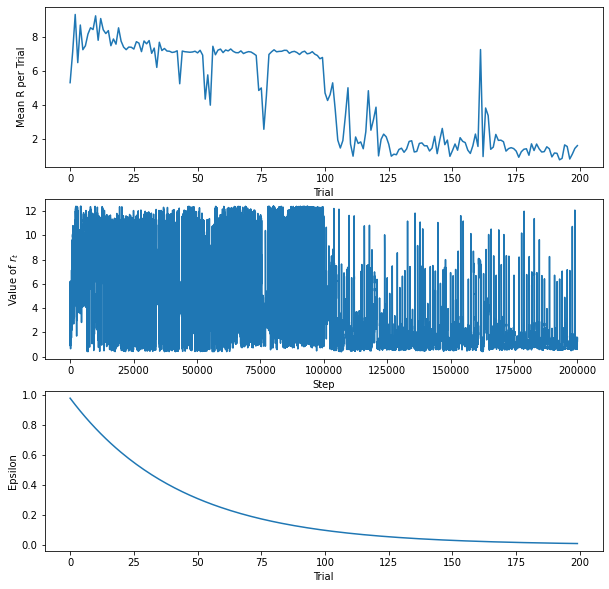

In [262]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

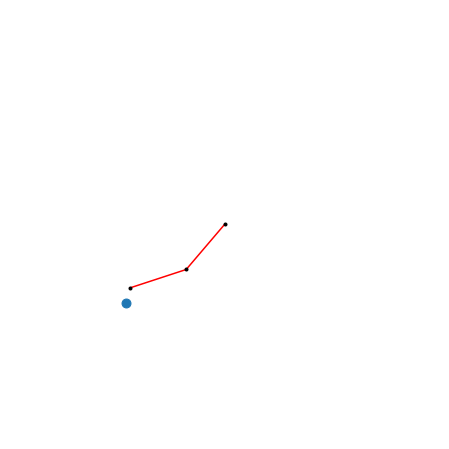

In [266]:
import numpy as np
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

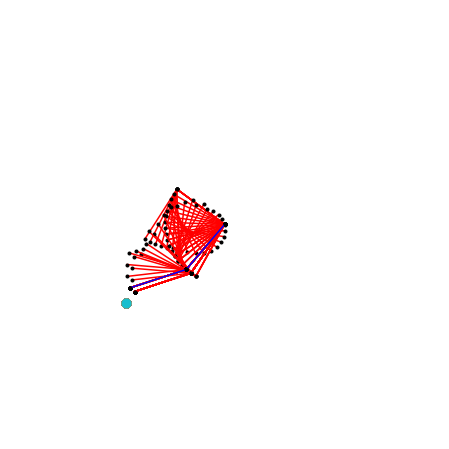

In [264]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

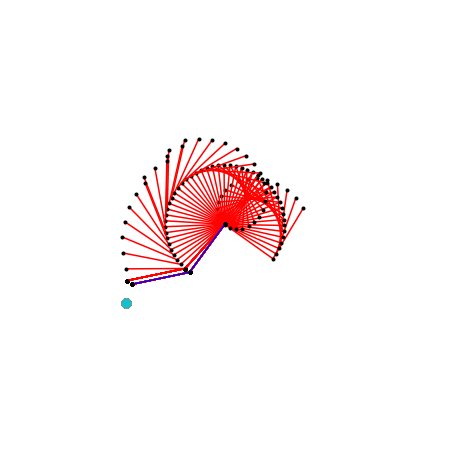

In [265]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

# Required Experiments

Show the results and discuss what you see. Which parameter values result in the best performance during and at the end of training?

## Good parameter values

Find values for parameters `n_hiddens_list`, `n_trials`, `n_steps_per_trial`, `n_scg_iterations`, and `gamma` that result in Mean R per Trial plot that shows fairly steady decrease to value close to 0. 

In [295]:
n_hiddens_lists= [[50, 10],[100,50]]
n_trials = [250,300]
n_steps_per_trials = [1000,1500]
n_scg_iterations = [4,8,12]
final_epsilon = [0.01,0.001]
gamma = 0.9
least_r_trace = np.inf
results=[]
np.random.seed(42)
for n_hiddens_list in n_hiddens_lists:
    for n_trail in n_trials:
        for n_steps_per_trial in n_steps_per_trials:
            for n_scg_iteration in n_scg_iterations:
                for final in final_epsilon:
                    Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trail,
                                                                   n_steps_per_trial, n_scg_iteration,
                                                                   final, gamma)

                    f_r_trace = r_mean_trace[-1]
                    if f_r_trace <= least_r_trace:
                        least_r_trace = f_r_trace

                        results.append([Qnet,Qnet.all_weights,r_mean_trace,r_trace,epsilon_trace,f_r_trace])


Trial 25: Mean R 7.09
Trial 50: Mean R 2.07
Trial 75: Mean R 0.95
Trial 100: Mean R 1.31
Trial 125: Mean R 1.42
Trial 150: Mean R 1.60
Trial 175: Mean R 0.84
Trial 200: Mean R 0.85
Trial 225: Mean R 0.74
Trial 250: Mean R 3.03
Trial 25: Mean R 7.39
Trial 50: Mean R 3.43
Trial 75: Mean R 3.37
Trial 100: Mean R 7.04
Trial 125: Mean R 6.94
Trial 150: Mean R 1.78
Trial 175: Mean R 2.91
Trial 200: Mean R 2.88
Trial 225: Mean R 4.42
Trial 250: Mean R 3.06
Trial 25: Mean R 2.33
Trial 50: Mean R 5.51
Trial 75: Mean R 0.83
Trial 100: Mean R 0.88
Trial 125: Mean R 0.69
Trial 150: Mean R 0.72
Trial 175: Mean R 0.71
Trial 200: Mean R 0.66
Trial 225: Mean R 0.71
Trial 250: Mean R 0.76
Trial 25: Mean R 2.93
Trial 50: Mean R 0.59
Trial 75: Mean R 1.33
Trial 100: Mean R 0.59
Trial 125: Mean R 2.54
Trial 150: Mean R 0.70
Trial 175: Mean R 0.56
Trial 200: Mean R 0.66
Trial 225: Mean R 0.58
Trial 250: Mean R 1.02
Trial 25: Mean R 2.87
Trial 50: Mean R 1.09
Trial 75: Mean R 1.02
Trial 100: Mean R 0.89
Tri

In [296]:
import pandas as pd
df = pd.DataFrame(results,columns=['Qnet','Qnet.all_weights','r_mean_trace','r_trace','epsilon_trace','final_r_mean'])


In [297]:
df

,Qnet,Qnet.all_weights,r_mean_trace,r_trace,epsilon_trace,final_r_mean
0,"NeuralNetwork(6, [50, 10], 1)","[-0.16959894209779164, 0.4675768807791985, 0.4...","[5.308253366508211, 7.723351194333612, 6.45198...","[[3.642856486454084], [3.30069378359442], [3.6...","[0.9817479430199844, 0.9638290236239705, 0.946...",3.032422
1,"NeuralNetwork(6, [50, 10], 1)","[-0.3520223250238447, -0.542020937857377, -0.1...","[5.505572912486342, 4.453170272634071, 8.04631...","[[11.406801768994615], [11.45983315828213], [1...","[0.9817479430199844, 0.9638290236239705, 0.946...",0.755612
2,"NeuralNetwork(6, [50, 10], 1)","[-0.011112384804031827, 0.09726461748879471, 0...","[5.770579454084697, 5.312309291180038, 6.68508...","[[5.383748247688171], [4.963596915080888], [4....","[0.9817479430199844, 0.9638290236239705, 0.946...",0.470679
3,"NeuralNetwork(6, [50, 10], 1)","[0.12219029787553301, -0.34816254962073706, 0....","[5.579847188461653, 9.768264276993854, 8.57289...","[[7.629408675481954], [7.357762657213233], [7....","[0.9817479430199844, 0.9638290236239705, 0.946...",0.456586
4,"NeuralNetwork(6, [50, 10], 1)","[0.09324041355772872, 0.2699504482806459, -0.4...","[8.357316185089642, 6.602046905444738, 6.12569...","[[8.1260871108803], [8.425941845329744], [8.35...","[0.9727472237769651, 0.9462371613657931, 0.920...",0.452767
5,"NeuralNetwork(6, [100, 50], 1)","[-0.25080230895568245, 0.2816527199077597, 0.0...","[8.775366311639683, 5.573412433239075, 4.69738...","[[11.433983054733092], [11.433983054733092], [...","[0.9727472237769651, 0.9462371613657931, 0.920...",0.447983


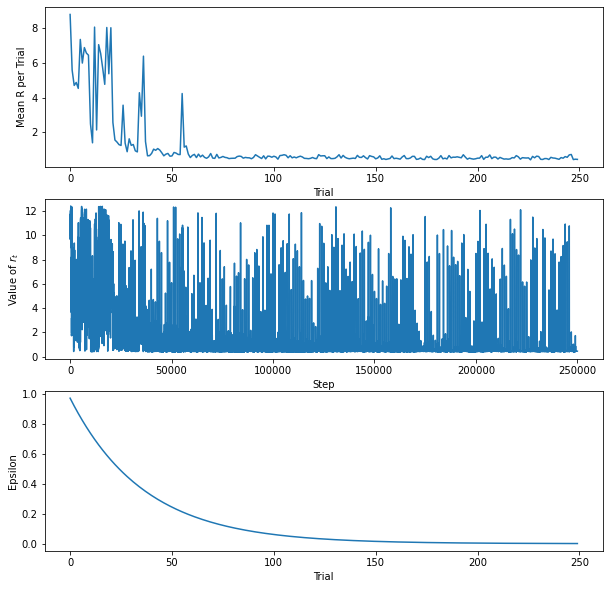

In [301]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(df['r_mean_trace'][5])
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(df['r_trace'][5])
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(df['epsilon_trace'][5])
plt.xlabel('Trial')
plt.ylabel('Epsilon');

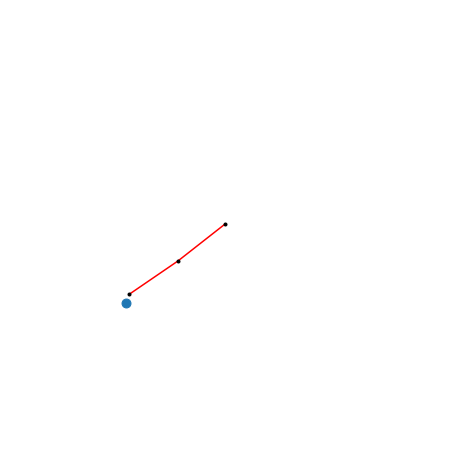

In [302]:
import numpy as np
np.random.seed(1234)
initial_state(robot)
robot.animate(100,df['Qnet'][5])

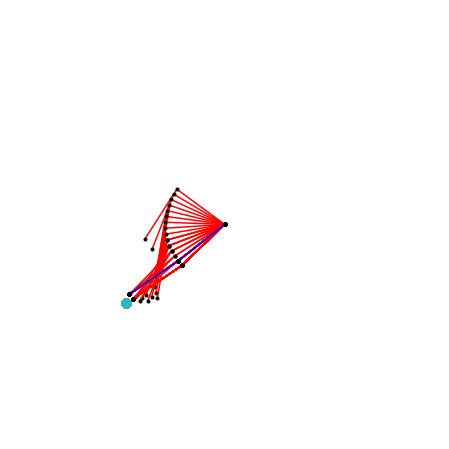

In [303]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, df['Qnet'][5], show_all_steps=True)

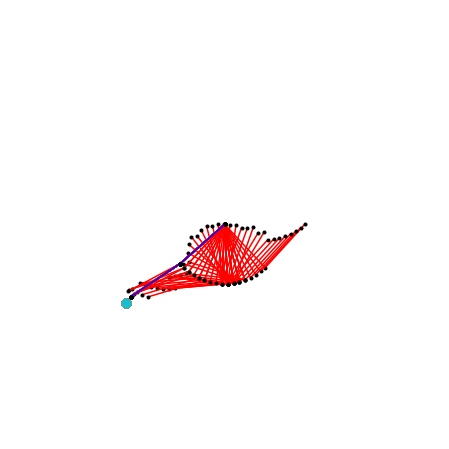

In [304]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, df['Qnet'][5], show_all_steps=True)

## Create robot with four links of lengths, 4, 3, 3,  and 2.

Again, find good values for the parameters. 

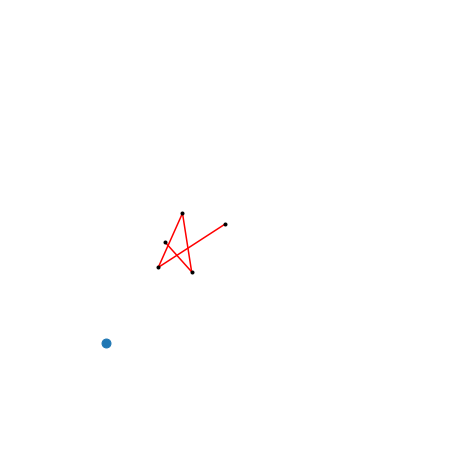

In [309]:
robot_4link = Robot([4, 3,3,2])
robot_4link.set_goal([4, 4])
robot_4link.animate(100)

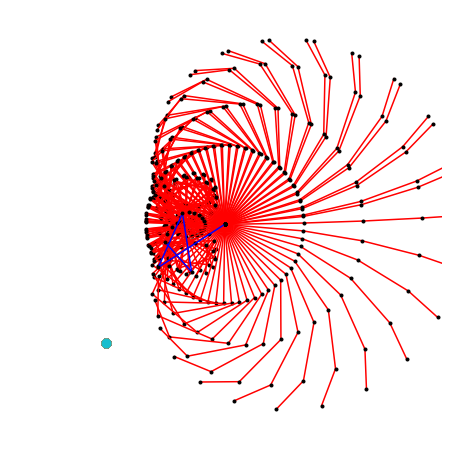

In [310]:
robot_4link = Robot([4, 3,3,2])
robot_4link.set_goal([4, 4])
robot_4link.animate(100, show_all_steps=True)

In [311]:
initial_state(robot_4link)


array([ 0.07833086,  0.61839774,  0.06483287, -0.35836233, -0.99692742,
       -0.78586528,  0.99789614,  0.93358258])

In [312]:
next_state(robot_4link, [-1, 1,1,-1])


array([ 0.88120784, -0.3271611 ,  0.87473   , -0.97920665, -0.47272904,
       -0.94496858,  0.4846106 ,  0.20286532])

In [313]:
reinforcement(robot_4link)


12.173785436752619

In [321]:
single_joint_actions = [-0.1, 0, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot_4link.n_links)))

In [322]:
robot_4link = Robot([4.,3.,3.,2.])
robot_4link.set_goal([4., 4.])

In [323]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot_4link, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 9.31
Trial 40: Mean R 8.64
Trial 60: Mean R 9.89
Trial 80: Mean R 8.65
Trial 100: Mean R 7.88
Trial 120: Mean R 7.93
Trial 140: Mean R 5.83
Trial 160: Mean R 5.29
Trial 180: Mean R 4.56
Trial 200: Mean R 4.56


In [331]:
n_hiddens_lists= [[50, 10],[100,50]]
n_trials = 300
n_steps_per_trials = [1000]
n_scg_iterations = 12
final_epsilon = 0.001
gamma = [0.9]
least_r_trace = np.inf
results1=[]
np.random.seed(42)
for n_hiddens_list in n_hiddens_lists:
    for n_steps_per_trial in n_steps_per_trials:
        for g in gamma:

            Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot_4link, n_hiddens_list, valid_actions, n_trials,
                                                           n_steps_per_trial, n_scg_iterations,
                                                           final_epsilon, g)

            f_r_trace = r_mean_trace[-1]
            if f_r_trace <= least_r_trace:
                least_r_trace = f_r_trace

                results1.append([Qnet,Qnet.all_weights,r_mean_trace,r_trace,epsilon_trace,f_r_trace])


Trial 30: Mean R 5.43
Trial 60: Mean R 1.63
Trial 90: Mean R 0.64
Trial 120: Mean R 1.03
Trial 150: Mean R 1.13
Trial 180: Mean R 1.98
Trial 210: Mean R 0.75
Trial 240: Mean R 1.05
Trial 270: Mean R 0.64
Trial 300: Mean R 0.52
Trial 30: Mean R 9.25
Trial 60: Mean R 3.41
Trial 90: Mean R 3.43
Trial 120: Mean R 1.38
Trial 150: Mean R 4.77
Trial 180: Mean R 4.29
Trial 210: Mean R 3.10
Trial 240: Mean R 2.15
Trial 270: Mean R 2.43
Trial 300: Mean R 2.21


In [332]:
import pandas as pd
df1 = pd.DataFrame(results1, columns=['Qnet','Qnet.all_weights','r_mean_trace','r_trace','epsilon_trace','final_r_mean'])
df1

,Qnet,Qnet.all_weights,r_mean_trace,r_trace,epsilon_trace,final_r_mean
0,"NeuralNetwork(12, [50, 10], 1)","[0.5190508149828746, 0.4910808544125812, -0.16...","[11.559913687884361, 9.157961910668654, 5.4918...","[[13.555941129391348], [13.197487043712483], [...","[0.9772372209558107, 0.9549925860214359, 0.933...",0.515805


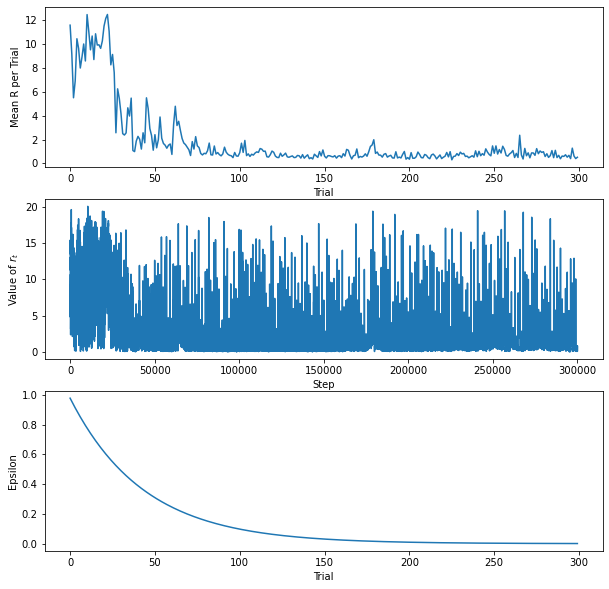

In [334]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(df1['r_mean_trace'][0])
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(df1['r_trace'][0])
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(df1['epsilon_trace'][0])
plt.xlabel('Trial')
plt.ylabel('Epsilon');

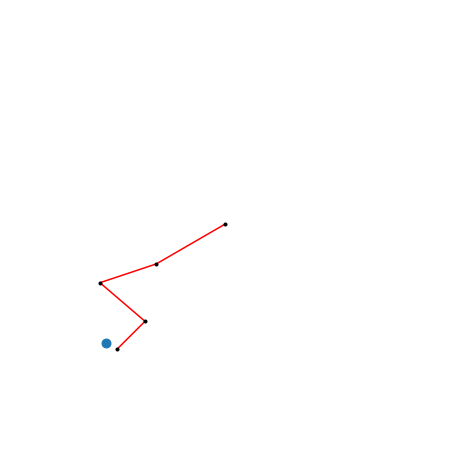

In [336]:
import numpy as np
np.random.seed(1234)
initial_state(robot)
robot_4link.animate(100,df1['Qnet'][0])

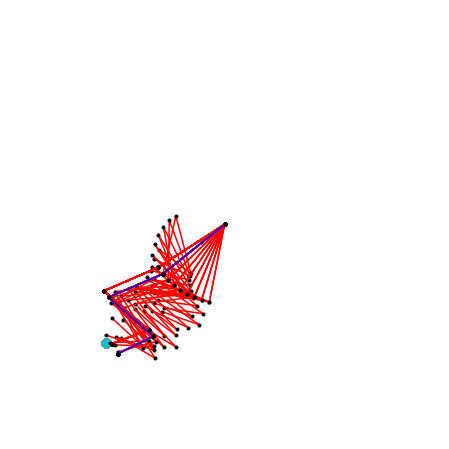

In [339]:
np.random.seed(4444)
initial_state(robot)
robot_4link.animate(100, df1['Qnet'][0], show_all_steps=True)

## Increase number of valid actions

We have been using just three different actions for each joint, `[-0.1, 0, 0.1]`.  Allow more precision in the control by changing this list of valid actions for each joint to `[-0.1, -0.05, 0, 0.05, 0.1]`.

As before, find good values for the parameters.

In [14]:
single_joint_actions = [-0.1, -0.05, 0, 0.05, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links)))

In [15]:
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

In [16]:
robot

In [17]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 7.53
Trial 40: Mean R 4.68
Trial 60: Mean R 1.44
Trial 80: Mean R 1.00
Trial 100: Mean R 1.25
Trial 120: Mean R 0.94
Trial 140: Mean R 0.95
Trial 160: Mean R 0.93
Trial 180: Mean R 0.83
Trial 200: Mean R 1.33


In [18]:
n_hiddens_lists= [[50, 10],[100,50]]
n_trials = [250,300]
n_steps_per_trials = 1000
n_scg_iterations = 12
final_epsilon = 0.001
gamma = [0.9,0.7]
least_r_trace = np.inf
results2=[]
np.random.seed(42)
for n_hiddens_list in n_hiddens_lists:
    for n_trial in n_trials:
        for g in gamma:

            Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trial,
                                                           n_steps_per_trials, n_scg_iterations,
                                                           final_epsilon, g)

            f_r_trace = r_mean_trace[-1]
            if f_r_trace <= least_r_trace:
                least_r_trace = f_r_trace

                results2.append([Qnet,Qnet.all_weights,r_mean_trace,r_trace,epsilon_trace,f_r_trace])


Trial 25: Mean R 5.51
Trial 50: Mean R 0.73
Trial 75: Mean R 0.69
Trial 100: Mean R 0.73
Trial 125: Mean R 0.70
Trial 150: Mean R 0.72
Trial 175: Mean R 0.84
Trial 200: Mean R 1.02
Trial 225: Mean R 0.89
Trial 250: Mean R 0.94
Trial 25: Mean R 1.66
Trial 50: Mean R 1.27
Trial 75: Mean R 1.31
Trial 100: Mean R 0.88
Trial 125: Mean R 0.59
Trial 150: Mean R 0.91
Trial 175: Mean R 0.55
Trial 200: Mean R 1.62
Trial 225: Mean R 0.64
Trial 250: Mean R 0.68
Trial 30: Mean R 0.88
Trial 60: Mean R 0.87
Trial 90: Mean R 0.64
Trial 120: Mean R 0.50
Trial 150: Mean R 0.52
Trial 180: Mean R 0.61
Trial 210: Mean R 0.62
Trial 240: Mean R 0.67
Trial 270: Mean R 0.51
Trial 300: Mean R 0.59
Trial 30: Mean R 1.61
Trial 60: Mean R 1.16
Trial 90: Mean R 0.83
Trial 120: Mean R 0.68
Trial 150: Mean R 0.82
Trial 180: Mean R 0.82
Trial 210: Mean R 1.21
Trial 240: Mean R 0.91
Trial 270: Mean R 0.61
Trial 300: Mean R 0.68
Trial 25: Mean R 4.28
Trial 50: Mean R 0.63
Trial 75: Mean R 0.55
Trial 100: Mean R 0.54
Tri

In [20]:
import pandas as pd
df2 = pd.DataFrame(results2,columns=['Qnet','Qnet.all_weights','r_mean_trace','r_trace','epsilon_trace','final_r_mean'])
df2

,Qnet,Qnet.all_weights,r_mean_trace,r_trace,epsilon_trace,final_r_mean
0,"NeuralNetwork(6, [50, 10], 1)","[-0.4274547053346217, 0.21969577105429816, 0.0...","[7.186406319307414, 10.715234782298124, 7.5555...","[[3.9132182990399076], [4.084615587628033], [3...","[0.9727472237769651, 0.9462371613657931, 0.920...",0.940748
1,"NeuralNetwork(6, [50, 10], 1)","[-0.31427576003298296, -0.4597659293327073, 0....","[6.211018093696259, 8.724257176058106, 8.71819...","[[5.42791553491391], [5.4583418190003945], [5....","[0.9727472237769651, 0.9462371613657931, 0.920...",0.682178
2,"NeuralNetwork(6, [50, 10], 1)","[0.47453032595512745, 0.1617712883260628, -0.6...","[4.349937462137711, 7.224970037251156, 4.76894...","[[5.853623860577743], [5.998742081015171], [6....","[0.9772372209558107, 0.9549925860214359, 0.933...",0.586626
3,"NeuralNetwork(6, [100, 50], 1)","[0.48227677673164, -0.5849656747903985, 0.1243...","[4.737979508911574, 7.380076572603731, 5.52766...","[[5.642160625128029], [5.810083803374768], [6....","[0.9727472237769651, 0.9462371613657931, 0.920...",0.558650
4,"NeuralNetwork(6, [100, 50], 1)","[0.33467011920778905, 0.12319695718270748, -0....","[8.718673494446259, 9.34870006520908, 5.323679...","[[7.858211467430717], [8.048783704144409], [8....","[0.9727472237769651, 0.9462371613657931, 0.920...",0.537513
5,"NeuralNetwork(6, [100, 50], 1)","[-0.3876156145192019, -0.4591361562168425, -0....","[6.115559023810005, 3.5702103348771135, 6.4809...","[[6.79510154302961], [6.679431944551262], [6.7...","[0.9772372209558107, 0.9549925860214359, 0.933...",0.460007


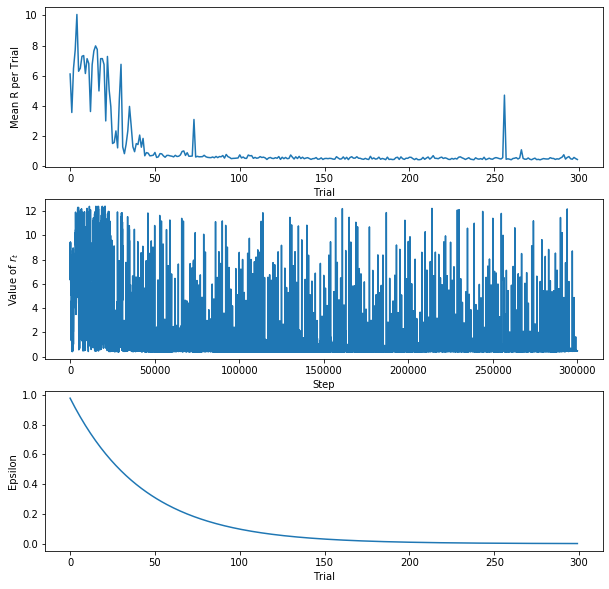

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(df2['r_mean_trace'][5])
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(df2['r_trace'][5])
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(df2['epsilon_trace'][5])
plt.xlabel('Trial')
plt.ylabel('Epsilon');

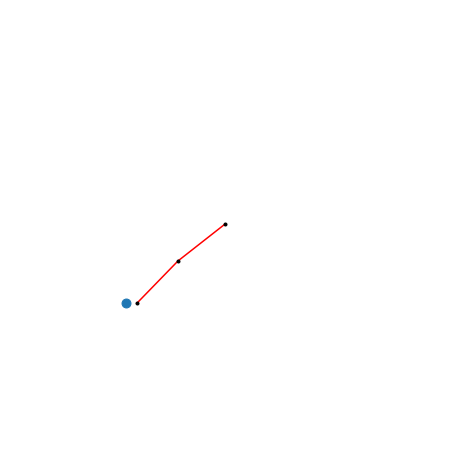

In [23]:
import numpy as np
np.random.seed(1234)
initial_state(robot)
robot.animate(100,df2['Qnet'][5])

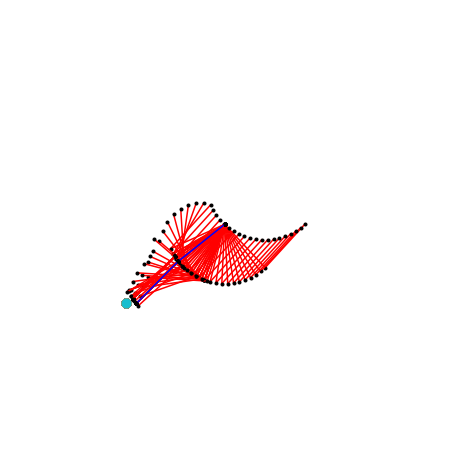

In [25]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, df2['Qnet'][5], show_all_steps=True)

## Observations:
1. Good parameter values for the default configuration:
        n_hiddens_lists= [100,50]
        n_trials = 250
        n_steps_per_trials = 1000
        n_scg_iterations = 12
        gamma = 0.9
        
2. Good Parameters for robot with four links:
        n_hiddens_lists= [50, 10]
        n_trials = 300
        n_steps_per_trials = 1000
        n_scg_iterations = 12
        gamma = 0.9
        
3. Good parameters with 4 valid action:
        n_hiddens_lists= [100, 50]
        n_trials = 300
        n_steps_per_trials = 1000
        n_scg_iterations = 12
        gamma = 0.9

4. The project was a good way to understand reinforcement learning where the model has a Q factor that make it work better by awarding positive and negative reinforncement. 

5. The longer the model is trained the better the response.

6. Even with a basic hiddenlist we can be able to achieve better results to control this project with the required outcome. 

7. Faor most cases the model has a very steady learning curve but in some cases there is spikes where the robot tries to work around new parameters and fails to do so. 

8. We can  observe that these are the points where the model had least r_mean_trace and thinks to try better but get of chart

9. When the final epsilon value was 0.001 the model started performing more better 

10. We can see for the 4 valid action configuration the r_mean_trace graph is near to zero at most points which suggest the model has converged sooner. 
        

# Extra Credit

As discussed in class for the marble control, make modifications to allow a variable goal.  Add the goal coordinates to the state input to the Qnet.  Demonstrate success by plotting `r_mean_trace` for four different, fixed, goals.

In [18]:
robot.goal=8
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)


Trial 20: Mean R 4.90
Trial 40: Mean R 4.01
Trial 60: Mean R 1.28
Trial 80: Mean R 0.99
Trial 100: Mean R 1.13
Trial 120: Mean R 0.98
Trial 140: Mean R 0.92
Trial 160: Mean R 1.23
Trial 180: Mean R 1.09
Trial 200: Mean R 1.09


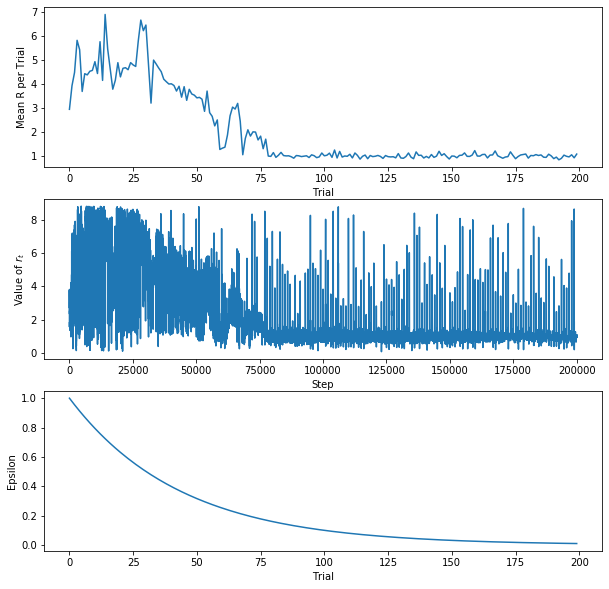

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [20]:
robot.goal=9
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)


Trial 20: Mean R 2.43
Trial 40: Mean R 0.94
Trial 60: Mean R 1.17
Trial 80: Mean R 1.07
Trial 100: Mean R 0.72
Trial 120: Mean R 0.34
Trial 140: Mean R 0.61
Trial 160: Mean R 0.67
Trial 180: Mean R 0.46
Trial 200: Mean R 0.43


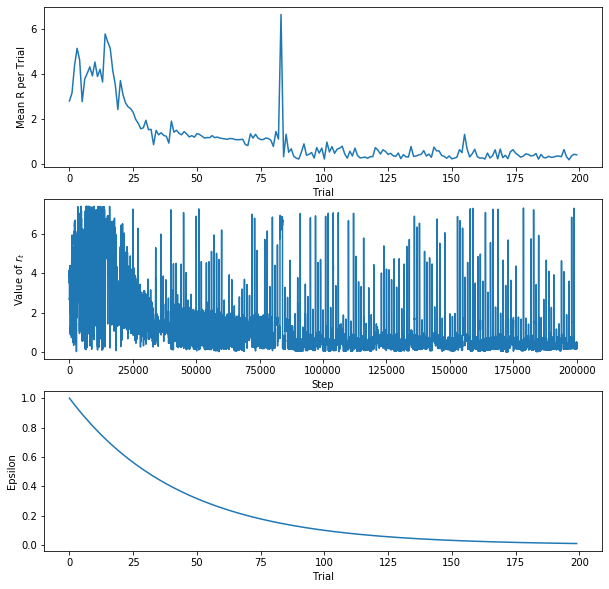

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [22]:
robot.goal=12
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)


Trial 20: Mean R 4.53
Trial 40: Mean R 5.52
Trial 60: Mean R 2.22
Trial 80: Mean R 0.47
Trial 100: Mean R 0.38
Trial 120: Mean R 0.41
Trial 140: Mean R 0.69
Trial 160: Mean R 0.39
Trial 180: Mean R 0.47
Trial 200: Mean R 0.46


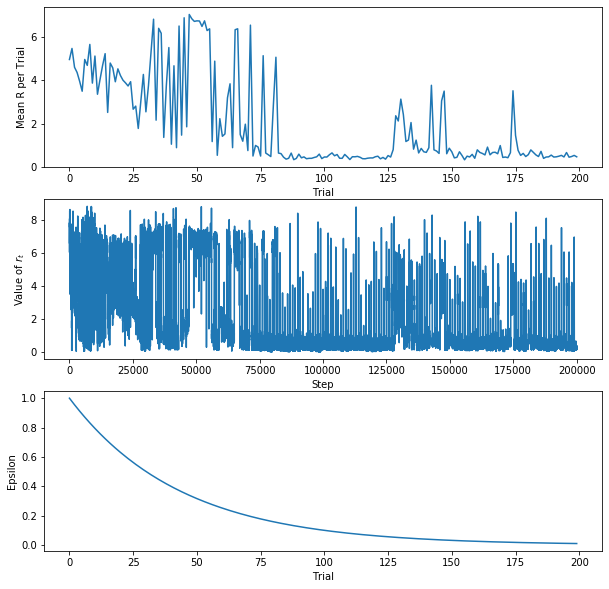

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

In [24]:
robot.goal=5
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)


Trial 20: Mean R 8.55
Trial 40: Mean R 7.87
Trial 60: Mean R 7.69
Trial 80: Mean R 6.36
Trial 100: Mean R 5.33
Trial 120: Mean R 6.94
Trial 140: Mean R 4.24
Trial 160: Mean R 4.15
Trial 180: Mean R 4.09
Trial 200: Mean R 4.13


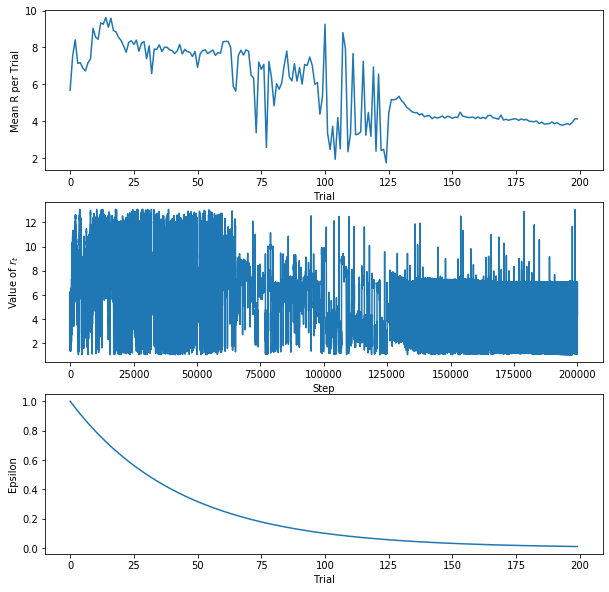

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

## Observation:

1. The goal variable was already present in the robot class. 
2. I used that to set the goal. 
3. From the output I can conclude that the higher the goal value the lower the R_mean_trace.  